['Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
None
--------------------------------------------------
         Survived      Pclass         Age       SibSp       Parch        Fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    

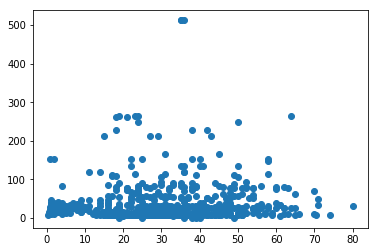

In [1]:
# modification on https://www.kaggle.com/startupsci/titanic-data-science-solutions
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

df = pd.read_csv("train.csv", index_col="PassengerId")
df_test = pd.read_csv("test.csv", index_col="PassengerId")

print(df.columns.values)

print(df.info())  # инфа по каждому столбцу (имя колво тип)
print("-"*50)

print(df.describe())  # немного статистики
print("-"*50)

print(df.head())  # первые пять строк
plt.scatter(df.Age, df.Fare)  # зависимость стоимости билета от возраста

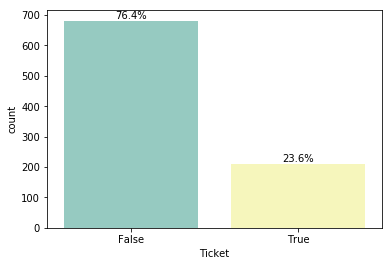

In [2]:
# check for duplicates
dup_tickets = df.Ticket.duplicated()
import seaborn as sns

ax = sns.countplot(x = dup_tickets,palette="Set3")
for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/len(dup_tickets)), (x.mean(), y), 
                ha='center', va='bottom')

In [3]:
# what about Cabin column?
df.Cabin.values[:30] # so many nans
# how many nans exactly?
df.Cabin.isnull().sum(), df.Cabin.isnull().sum()/len(df.Cabin)

(687, 0.77104377104377109)

In [4]:
# what about class -> survivial relation?
df[['Pclass', 'Survived']].groupby(['Pclass']).mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [5]:
df[['Sex', 'Survived']].groupby(['Sex']).mean()

,Survived
Sex,
female,0.742038
male,0.188908


In [6]:
df[["SibSp", "Survived"]].groupby(['SibSp']).mean().sort_values(by='Survived', ascending=False)

,Survived
SibSp,
1,0.535885
2,0.464286
0,0.345395
3,0.250000
4,0.166667
5,0.000000
8,0.000000


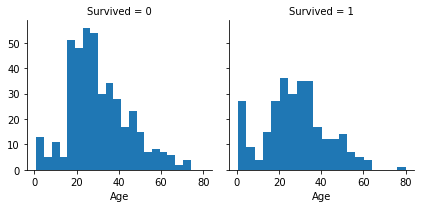

In [7]:
g = sns.FacetGrid(df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

In [8]:
df_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [9]:
# is there any NaN values left?
df.isnull().values.any()

True

In [10]:
for dataset in (df, df_test):
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

In [11]:
df.Sex.head()

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Sex, dtype: int64

In [12]:
df.Sex.isnull().values.any(), df_test.Sex.isnull().values.any(), df.Age.isnull().values.any(), df_test.Age.isnull().values.any()

(False, False, True, True)

In [13]:
"""
Completing a numerical continuous feature

Now we should start estimating and completing features with missing or null values.
We will first do this for the Age feature.

We can consider three methods to complete a numerical continuous feature.

    1.A simple way is to generate random numbers between mean and standard deviation.

    2.More accurate way of guessing missing values is to use other correlated features.
    In our case we note correlation among Age, Gender, and Pclass.
    Guess Age values using median values for Age across sets of Pclass and Gender feature combinations.
    So, median Age for Pclass=1 and Gender=0, Pclass=1 and Gender=1, and so on...

    3.Combine methods 1 and 2. So instead of guessing age values based on median,
    use random numbers between mean and standard deviation, based on sets of Pclass and Gender combinations.

Method 1 and 3 will introduce random noise into our models. The results from multiple executions might vary.
We will prefer method 2.
"""
guess_ages = np.zeros((2,3))
guess_ages
    

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [14]:
for dataset in (df, df_test):
    for sex in range(2): # male female
        for cls in range(1, 4): # 1 2 3
            group_df =  dataset[(dataset['Sex'] == sex) & (dataset['Pclass'] == cls)]['Age'].dropna()
            
            age_guess = group_df.mean()
            
            guess_ages[sex,cls-1] = round(age_guess, 1)
            
    for i in range(2):
        for j in range(3):
            dataset.loc[(dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j + 1), 'Age'] = guess_ages[i, j]
            
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S


In [15]:
for dataset in (df, df_test):    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,1.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",1,1.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",0,2.0,0,0,373450,8.0500,NaN,S


In [16]:
for dataset in (df, df_test):
    dataset['Embarked'] = dataset['Embarked'].fillna(df.Embarked.mode()[0])
    
df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [17]:
for dataset in (df, df_test):
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
df[['Embarked', 'Survived']].groupby(['Embarked']).mean().sort_values(by='Survived', ascending=False)

,Survived
Embarked,
1,0.553571
2,0.389610
0,0.339009


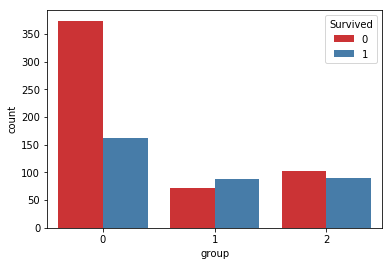

In [18]:
"""Time to find people who cared about each other"""
for dataset in (df, df_test):
    dataset['group'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[(dataset['group'] >= 2) & (dataset['Age'] <= 3), 'group'] = 2
    dataset.loc[dataset['group'] >= 4, 'group'] = 3
ax = sns.countplot(x = df.group, hue=df.Survived, palette="Set1")

In [19]:
df_test.Fare.fillna(df_test.Fare.dropna().median(), inplace=True)

In [20]:
for dataset in (df, df_test):
    dataset.drop('Name', axis=1, inplace=True)
    dataset.drop('Ticket', axis=1, inplace=True)
    dataset.drop('Cabin', axis=1, inplace=True)
    dataset.drop('Parch', axis=1, inplace=True)
    dataset.drop('SibSp', axis=1, inplace=True)    
    print(dataset.head())

             Survived  Pclass  Sex  Age     Fare  Embarked  group
PassengerId                                                      
1                   0       3    0  1.0   7.2500         0      1
2                   1       1    1  2.0  71.2833         1      1
3                   1       3    1  1.0   7.9250         0      0
4                   1       1    1  2.0  53.1000         0      1
5                   0       3    0  2.0   8.0500         0      0
             Pclass  Sex  Age     Fare  Embarked  group
PassengerId                                            
892               3    0  2.0   7.8292         2      0
893               3    1  2.0   7.0000         0      1
894               2    0  3.0   9.6875         2      0
895               3    0  1.0   8.6625         0      0
896               3    1  1.0  12.2875         0      2


In [21]:
df_test.isnull().values.any(), df.isnull().values.any()  # there no more Nan values


(False, False)

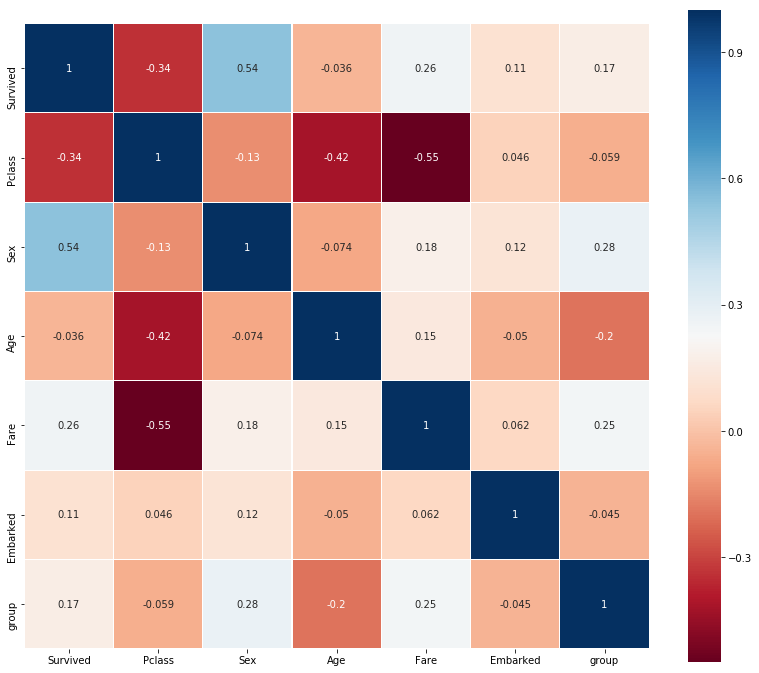

In [22]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [23]:
"""Our problem is a classification and regression problem. We want to identify relationship between output (Survived or not) with other variables or features (Gender, Age, Port...). We are also perfoming a category of machine learning which is called supervised learning as we are training our model with a given dataset. With these two criteria - Supervised Learning plus Classification and Regression, we can narrow down our choice of models to a few. These include:

    Logistic Regression
    KNN or k-Nearest Neighbors
    Support Vector Machines
    Naive Bayes classifier
    Decision Tree
    Random Forrest
    Perceptron
    Artificial neural network
    RVM or Relevance Vector Machine
"""
X_train = df.drop("Survived", axis=1)
Y_train = df["Survived"]
X_test  = df_test.copy()
X_train.shape, Y_train.shape, X_test.shape


((891, 6), (891,), (418, 6))

In [24]:
# machine learning
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, scale
from sklearn.metrics import accuracy_score, roc_curve
from tqdm import tqdm_notebook as tqdm


In [25]:
"""Score on kaggle is 0.74162 which is bad and like 8500 place on leadersboard.
I don't like how accuracy scoring is getting here. I should add KFold validation.
Theres a person who got 0.81 https://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html
catboost from yandex https://www.kaggle.com/pacifik80/yandex-catboost-demo/output
"""
kf = KFold(5)

# data normalization
X_train, X_test = scale(X_train), scale(X_test)

In [26]:
# Logistic Regression
logreg = LogisticRegression()
scores = []
for k, (train, test) in enumerate(kf.split(X_train, Y_train)):
    logreg.fit(X_train[train], Y_train.iloc[train])
    print(f"fold {k}, score: {logreg.score(X_train, Y_train)}")
    scores.append(logreg.score(X_train, Y_train))
    
print("avg score:", round(sum(scores)/len(scores), 5))
# Y_pred = logreg.predict(X_test)
acc_log = logreg.score(X_train, Y_train)  # accuracy_score()
# f'{round(acc_log, 5)}'


logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)

log_features = logreg.coef_
submission = pd.DataFrame({
        "PassengerId": df_test.index,
        "Survived": Y_pred
    })

submission.to_csv('LogReg.csv', index=False)

fold 0, score: 0.7878787878787878
fold 1, score: 0.7934904601571269
fold 2, score: 0.7934904601571269
fold 3, score: 0.7957351290684624
fold 4, score: 0.792368125701459
avg score: 0.79259


In [27]:
# Support Vector Classification

svc = SVC()
scores = []
for k, (train, test) in enumerate(kf.split(X_train, Y_train)):
    svc.fit(X_train[train], Y_train.iloc[train])
    print(f"fold {k}, score: {logreg.score(X_train, Y_train)}")
    scores.append(svc.score(X_train, Y_train))
    
print("avg score:", round(sum(scores)/len(scores), 5))

svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = svc.score(X_train, Y_train)
print(f'{round(acc_svc, 5)}')

submission = pd.DataFrame({
        "PassengerId": df_test.index,
        "Survived": Y_pred
    })

submission.to_csv('SVC.csv', index=False)


fold 0, score: 0.7946127946127947
fold 1, score: 0.7946127946127947
fold 2, score: 0.7946127946127947
fold 3, score: 0.7946127946127947
fold 4, score: 0.7946127946127947
avg score: 0.82896
0.82941


In [28]:
# KNN

knn = KNeighborsClassifier(n_neighbors = 3)
scores = []
for k, (train, test) in enumerate(kf.split(X_train, Y_train)):
    knn.fit(X_train[train], Y_train.iloc[train])
    print(f"fold {k}, score: {logreg.score(X_train, Y_train)}")
    scores.append(svc.score(X_train, Y_train))
    
print("avg score:", round(sum(scores)/len(scores), 5))

knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = knn.score(X_train, Y_train)

submission = pd.DataFrame({
        "PassengerId": df_test.index,
        "Survived": Y_pred
    })

submission.to_csv('KNN.csv', index=False)

f'{round(acc_knn, 5)}'  # less than here https://www.kaggle.com/startupsci/titanic-data-science-solutions

fold 0, score: 0.7946127946127947
fold 1, score: 0.7946127946127947
fold 2, score: 0.7946127946127947
fold 3, score: 0.7946127946127947
fold 4, score: 0.7946127946127947
avg score: 0.82941


'0.86195'

In [29]:
# Gaussian Naive Bayes

gaussian = GaussianNB()

scores = []
for k, (train, test) in enumerate(kf.split(X_train, Y_train)):
    gaussian.fit(X_train[train], Y_train.iloc[train])
    print(f"fold {k}, score: {logreg.score(X_train, Y_train)}")
    scores.append(gaussian.score(X_train, Y_train))
    
print("avg score:", round(sum(scores)/len(scores), 5))

gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = gaussian.score(X_train, Y_train)
submission = pd.DataFrame({
        "PassengerId": df_test.index,
        "Survived": Y_pred
    })

submission.to_csv('GaussianNB.csv', index=False)
f'{round(acc_gaussian, 5)}'

fold 0, score: 0.7946127946127947
fold 1, score: 0.7946127946127947
fold 2, score: 0.7946127946127947
fold 3, score: 0.7946127946127947
fold 4, score: 0.7946127946127947
avg score: 0.7798


'0.7789'

In [30]:
# Perceptron

perceptron = Perceptron()

scores = []
for k, (train, test) in enumerate(kf.split(X_train, Y_train)):
    perceptron.fit(X_train[train], Y_train.iloc[train])
    print(f"fold {k}, score: {logreg.score(X_train, Y_train)}")
    scores.append(perceptron.score(X_train, Y_train))
    
print("avg score:", round(sum(scores)/len(scores), 5))


perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = perceptron.score(X_train, Y_train)
f'{round(acc_perceptron, 5)}'

fold 0, score: 0.7946127946127947
fold 1, score: 0.7946127946127947
fold 2, score: 0.7946127946127947
fold 3, score: 0.7946127946127947
fold 4, score: 0.7946127946127947
avg score: 0.66622


/home/grail/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


'0.78563'

In [31]:
# Linear SVC

linear_svc = LinearSVC()

scores = []
for k, (train, test) in enumerate(kf.split(X_train, Y_train)):
    linear_svc.fit(X_train[train], Y_train.iloc[train])
    print(f"fold {k}, score: {logreg.score(X_train, Y_train)}")
    scores.append(linear_svc.score(X_train, Y_train))
print("avg score:", round(sum(scores)/len(scores), 5))

linear_svc.fit(X_train, Y_train)
svc_features = linear_svc.coef_
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = linear_svc.score(X_train, Y_train)
f'{round(acc_linear_svc, 5)}'

fold 0, score: 0.7946127946127947
fold 1, score: 0.7946127946127947
fold 2, score: 0.7946127946127947
fold 3, score: 0.7946127946127947
fold 4, score: 0.7946127946127947
avg score: 0.79349


'0.79574'

In [32]:
# Stochastic Gradient Descent

sgd = SGDClassifier()

scores = []
for k, (train, test) in enumerate(kf.split(X_train, Y_train)):
    sgd.fit(X_train[train], Y_train.iloc[train])
    print(f"fold {k}, score: {logreg.score(X_train, Y_train)}")
    scores.append(sgd.score(X_train, Y_train))
print("avg score:", round(sum(scores)/len(scores), 5))

sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = sgd.score(X_train, Y_train)
f'{round(acc_sgd, 5)}'

fold 0, score: 0.7946127946127947
fold 1, score: 0.7946127946127947
fold 2, score: 0.7946127946127947
fold 3, score: 0.7946127946127947
fold 4, score: 0.7946127946127947
avg score: 0.69719


/home/grail/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


'0.74635'

In [33]:
# Decision Tree

decision_tree = DecisionTreeClassifier()

scores = []
for k, (train, test) in enumerate(kf.split(X_train, Y_train)):
    decision_tree.fit(X_train[train], Y_train.iloc[train])
    print(f"fold {k}, score: {logreg.score(X_train, Y_train)}")
    scores.append(decision_tree.score(X_train, Y_train))
print("avg score:", round(sum(scores)/len(scores), 5))

decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = decision_tree.score(X_train, Y_train)
submission = pd.DataFrame({
        "PassengerId": df_test.index,
        "Survived": Y_pred
    })

submission.to_csv('DecisionTree.csv', index=False)
f'{round(acc_decision_tree, 5)}'

fold 0, score: 0.7946127946127947
fold 1, score: 0.7946127946127947
fold 2, score: 0.7946127946127947
fold 3, score: 0.7946127946127947
fold 4, score: 0.7946127946127947
avg score: 0.9147


'0.94052'

In [34]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)

scores = []
for k, (train, test) in enumerate(kf.split(X_train, Y_train)):
    random_forest.fit(X_train[train], Y_train.iloc[train])
    print(f"fold {k}, score: {logreg.score(X_train, Y_train)}")
    scores.append(random_forest.score(X_train, Y_train))
print("avg score:", round(sum(scores)/len(scores), 5))

random_forest.fit(X_train, Y_train)
rf_features = random_forest.feature_importances_
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = random_forest.score(X_train, Y_train)
f'{round(acc_random_forest, 5)}'

fold 0, score: 0.7946127946127947
fold 1, score: 0.7946127946127947
fold 2, score: 0.7946127946127947
fold 3, score: 0.7946127946127947
fold 4, score: 0.7946127946127947
avg score: 0.9138


'0.94052'

In [35]:
scores = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
scores.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,0.940516
8,Decision Tree,0.940516
1,KNN,0.861953
0,Support Vector Machines,0.829405
7,Linear SVC,0.795735
2,Logistic Regression,0.792368
5,Perceptron,0.785634
4,Naive Bayes,0.778900
6,Stochastic Gradient Decent,0.746352


In [36]:
# https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python/notebook
cols = df.columns.values
# Create a dataframe with features
print(cols)
print(len(rf_features),len(svc_features),len(log_features), len(cols))

# feature_dataframe = pd.DataFrame( {'features': cols,
#      'Random Forest feature importances': rf_features,
#      'SVC  feature importances': svc_features,
#     'LogReg feature importances': log_features
#     })

# feature_dataframe

['Survived' 'Pclass' 'Sex' 'Age' 'Fare' 'Embarked' 'group']
6 1 1 7
